# Рисование трендов на графике

In [2]:
%matplotlib inline
import operator
import numpy as np
import pandas as pd
import talib
import math
from datetime import date, timedelta

import statsmodels
from statsmodels.tsa.stattools import adfuller

import seaborn
import matplotlib.pyplot as plt

from db import db, prices, get_performance

/home/alex/env/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# get price history from local db
def from_db(symbol, period=1000):
    all_prices = prices([symbol], date.today(), period)

    return np.array([x[1] for x in all_prices]), np.array([x[5] for x in all_prices])

In [4]:
# get price history from Yahoo! Finance with Pandas
def from_yahoo(symbol):
    import pandas as pd
    import pandas_datareader.data as web

    start = date(2010,1,1)
    end = date.today()
    prices_df = web.DataReader(symbol, "yahoo", start, end)

    return prices_df.index, prices_df.as_matrix(columns=['Adj Close'])

In [5]:
# Idea: https://github.com/dysonance/Trendy
def gentrends(x, window=1/3.0, charts=True):
    """
    Returns a Pandas dataframe with support and resistance lines.
    :param x: One-dimensional data set
    :param window: How long the trendlines should be. If window < 1, then it
                   will be taken as a percentage of the size of the data
    :param charts: Boolean value saying whether to print chart to screen
    """

    import numpy as np
    import pandas as pd

    x = np.array(x)

    if window < 1:
        window = int(window * len(x))

    max1 = np.where(x == max(x))[0][0]  # find the index of the abs max
    min1 = np.where(x == min(x))[0][0]  # find the index of the abs min

    # First the max
    if max1 + window > len(x):
        max2 = max(x[0:(max1 - window)])
    else:
        max2 = max(x[(max1 + window):])

    # Now the min
    if min1 - window < 0:
        min2 = min(x[(min1 + window):])
    else:
        min2 = min(x[0:(min1 - window)])

    # Now find the indices of the secondary extrema
    max2 = np.where(x == max2)[0][0]  # find the index of the 2nd max
    min2 = np.where(x == min2)[0][0]  # find the index of the 2nd min

    # Create & extend the lines
    maxslope = (x[max1] - x[max2]) / (max1 - max2)  # slope between max points
    minslope = (x[min1] - x[min2]) / (min1 - min2)  # slope between min points
    a_max = x[max1] - (maxslope * max1)  # y-intercept for max trendline
    a_min = x[min1] - (minslope * min1)  # y-intercept for min trendline
    b_max = x[max1] + (maxslope * (len(x) - max1))  # extend to last data pt
    b_min = x[min1] + (minslope * (len(x) - min1))  # extend to last data point
    maxline = np.linspace(a_max, b_max, len(x))  # Y values between max's
    minline = np.linspace(a_min, b_min, len(x))  # Y values between min's

    # OUTPUT
    trends = np.transpose(np.array((x, maxline, minline)))
    trends = pd.DataFrame(trends, index=np.arange(0, len(x)),
                          columns=['Data', 'Max Line', 'Min Line'])

    if charts is True:
        from matplotlib.pyplot import plot, grid, show
        plot(trends)
        grid()
        show()

    return trends, maxslope, minslope

def segtrends(x, segments=2, charts=True):
    """
    Turn minitrends to iterative process more easily adaptable to
    implementation in simple trading systems; allows backtesting functionality.
    :param x: One-dimensional data set
    :param window: How long the trendlines should be. If window < 1, then it
                   will be taken as a percentage of the size of the data
    :param charts: Boolean value saying whether to print chart to screen
    """

    import numpy as np
    y = np.array(x)

    # Implement trendlines
    segments = int(segments)
    maxima = np.ones(segments)
    minima = np.ones(segments)
    segsize = int(len(y)/segments)
    for i in range(1, segments+1):
        ind2 = i*segsize
        ind1 = ind2 - segsize
        maxima[i-1] = max(y[ind1:ind2])
        minima[i-1] = min(y[ind1:ind2])

    # Find the indexes of these maxima in the data
    x_maxima = np.ones(segments)
    x_minima = np.ones(segments)
    for i in range(0, segments):
        x_maxima[i] = np.where(y == maxima[i])[0][0]
        x_minima[i] = np.where(y == minima[i])[0][0]

    if charts:
        import matplotlib.pyplot as plt
        plt.plot(y)
        plt.grid(True)

    for i in range(0, segments-1):
        maxslope = (maxima[i+1] - maxima[i]) / (x_maxima[i+1] - x_maxima[i])
        a_max = maxima[i] - (maxslope * x_maxima[i])
        b_max = maxima[i] + (maxslope * (len(y) - x_maxima[i]))
        maxline = np.linspace(a_max, b_max, len(y))

        minslope = (minima[i+1] - minima[i]) / (x_minima[i+1] - x_minima[i])
        a_min = minima[i] - (minslope * x_minima[i])
        b_min = minima[i] + (minslope * (len(y) - x_minima[i]))
        minline = np.linspace(a_min, b_min, len(y))

        if charts:
            plt.plot(maxline, 'g')
            plt.plot(minline, 'r')

    if charts:
        plt.show()

    # OUTPUT
    return x_maxima, maxima, x_minima, minima

def minitrends(x, window=20, charts=True):
    """
    Turn minitrends to iterative process more easily adaptable to
    implementation in simple trading systems; allows backtesting functionality.
    :param x: One-dimensional data set
    :param window: How long the trendlines should be. If window < 1, then it
                   will be taken as a percentage of the size of the data
    :param charts: Boolean value saying whether to print chart to screen
    """

    import numpy as np

    y = np.array(x)
    if window < 1:  # if window is given as fraction of data length
        window = float(window)
        window = int(window * len(y))
    x = np.arange(0, len(y))
    dy = y[window:] - y[:-window]
    crit = dy[:-1] * dy[1:] < 0

    # Find whether max's or min's
    maxi = (y[x[crit]] - y[x[crit] + window] > 0) & \
           (y[x[crit]] - y[x[crit] - window] > 0) * 1
    mini = (y[x[crit]] - y[x[crit] + window] < 0) & \
           (y[x[crit]] - y[x[crit] - window] < 0) * 1
    maxi = maxi.astype(float)
    mini = mini.astype(float)
    maxi[maxi == 0] = np.nan
    mini[mini == 0] = np.nan
    xmax = x[crit] * maxi
    xmax = xmax[~np.isnan(xmax)]
    xmax = xmax.astype(int)
    xmin = x[crit] * mini
    xmin = xmin[~np.isnan(xmin)]
    xmin = xmin.astype(int)

    # See if better max or min in region
    yMax = np.array([])
    xMax = np.array([])
    for i in xmax:
        indx = np.where(xmax == i)[0][0] + 1
        try:
            Y = y[i:xmax[indx]]
            yMax = np.append(yMax, Y.max())
            xMax = np.append(xMax, np.where(y == yMax[-1])[0][0])
        except:
            pass
    yMin = np.array([])
    xMin = np.array([])
    for i in xmin:
        indx = np.where(xmin == i)[0][0] + 1
        try:
            Y = y[i:xmin[indx]]
            yMin = np.append(yMin, Y.min())
            xMin = np.append(xMin, np.where(y == yMin[-1])[0][0])
        except:
            pass
    if y[-1] > yMax[-1]:
        yMax = np.append(yMax, y[-1])
        xMax = np.append(xMax, x[-1])
    if y[0] not in yMax:
        yMax = np.insert(yMax, 0, y[0])
        xMax = np.insert(xMax, 0, x[0])
    if y[-1] < yMin[-1]:
        yMin = np.append(yMin, y[-1])
        xMin = np.append(xMin, x[-1])
    if y[0] not in yMin:
        yMin = np.insert(yMin, 0, y[0])
        xMin = np.insert(xMin, 0, x[0])

    # Plot results if desired
    if charts is True:
        from matplotlib.pyplot import plot, show, grid
        plot(x, y)
        plot(xMax, yMax, '-o')
        plot(xMin, yMin, '-o')
        grid(True)
        show()
    # Return arrays of critical points
    return xMax, yMax, xMin, yMin

def iterlines(x, window=30, charts=True):
    """
    Turn minitrends to iterative process more easily adaptable to
    implementation in simple trading systems; allows backtesting functionality.
    :param x: One-dimensional data set
    :param window: How long the trendlines should be. If window < 1, then it
                   will be taken as a percentage of the size of the data
    :param charts: Boolean value saying whether to print chart to screen
    """

    import numpy as np

    x = np.array(x)
    n = len(x)
    if window < 1:
        window = int(window * n)
    sigs = np.zeros(n, dtype=float)

    i = window
    while i != n:
        if x[i] > max(x[i-window:i]): sigs[i] = 1
        elif x[i] < min(x[i-window:i]): sigs[i] = -1
        i += 1

    xmin = np.where(sigs == -1.0)[0]
    xmax = np.where(sigs == 1.0)[0]
    ymin = x[xmin]
    ymax = x[xmax]
    if charts is True:
        from matplotlib.pyplot import plot, grid, show
        plot(x)
        plot(xmin, ymin, 'ro')
        plot(xmax, ymax, 'go')
        grid(True)
        show()

    return sigs

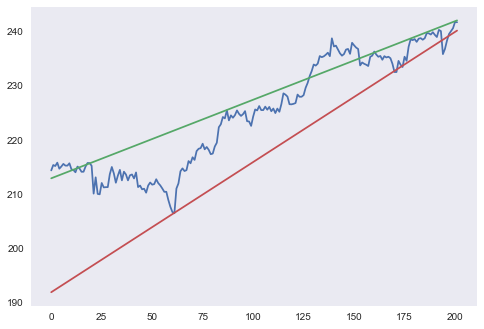

(         Data    Max Line    Min Line
 0    214.3364  212.875575  191.828376
 1    215.3311  213.020716  192.068870
 2    215.1439  213.165857  192.309365
 3    215.7644  213.310997  192.549859
 4    214.6515  213.456138  192.790353
 5    215.0553  213.601278  193.030847
 6    215.5379  213.746419  193.271342
 7    215.2227  213.891560  193.511836
 8    215.2129  214.036700  193.752330
 9    215.6462  214.181841  193.992824
 10   214.5432  214.326982  194.233318
 11   214.3955  214.472122  194.473813
 12   213.9917  214.617263  194.714307
 13   215.0462  214.762404  194.954801
 14   214.6909  214.907544  195.195295
 15   214.0803  215.052685  195.435790
 16   214.0902  215.197825  195.676284
 17   215.0553  215.342966  195.916778
 18   215.7061  215.488107  196.157272
 19   215.6856  215.633247  196.397767
 20   215.1932  215.778388  196.638261
 21   210.0426  215.923529  196.878755
 22   213.0561  216.068669  197.119249
 23   209.9933  216.213810  197.359744
 24   209.9145  216.35895

In [12]:
dates, data = from_db('SPY', period=300)
# Generate general support/resistance trendlines and show the chart
# winow < 1 is considered a fraction of the length of the data set
gentrends(data, window = 1./2, charts = True)

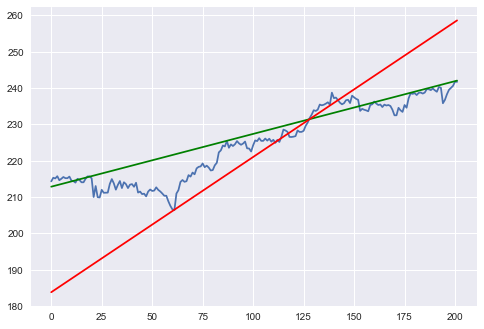

(array([  87.,  200.]),
 array([ 225.4403,  241.76  ]),
 array([  61.,  111.]),
 array([ 206.4259,  224.9297]))

In [13]:
# Generate a series of support/resistance lines by segmenting the price history
segtrends(data, segments = 2, charts = True)  # equivalent to gentrends with window of 1/2

/home/alex/env/lib/python3.5/site-packages/ipykernel_launcher.py:139: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 202 but corresponding boolean dimension is 181
/home/alex/env/lib/python3.5/site-packages/ipykernel_launcher.py:140: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 202 but corresponding boolean dimension is 181
/home/alex/env/lib/python3.5/site-packages/ipykernel_launcher.py:145: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 202 but corresponding boolean dimension is 181
/home/alex/env/lib/python3.5/site-packages/ipykernel_launcher.py:148: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 202 but corresponding boolean dimension is 181


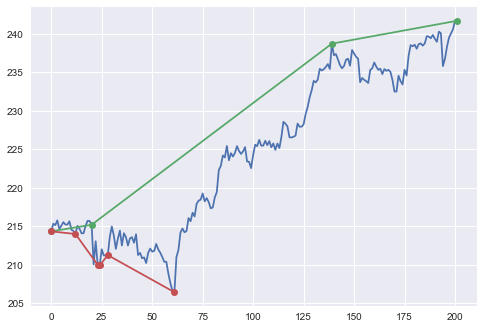

(array([   0.,   20.,  139.,  201.]),
 array([ 214.3364,  215.1932,  238.7395,  241.71  ]),
 array([  0.,  12.,  23.,  24.,  28.,  61.]),
 array([ 214.3364,  213.9917,  209.9933,  209.9145,  211.2463,  206.4259]))

In [14]:
# Generate smaller support/resistance trendlines to frame price over smaller periods
minitrends(data, window = 20, charts = True)

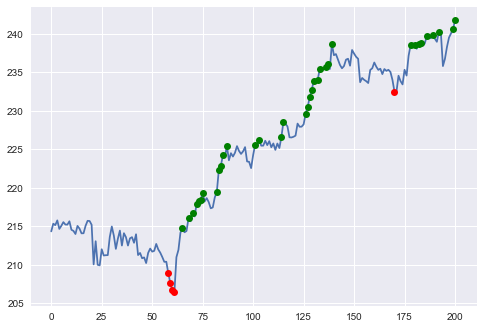

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0., -1., -1., -1., -1.,  0.,  0.,  0.,
        1.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,
        1.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1

In [15]:
# Iteratively generate trading signals based on maxima/minima in given window
iterlines(data, window = 30, charts = True)  # buy at green dots, sell at red dots